# Generative Adversarial Networks

In [1]:
%matplotlib inline
import os
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K
from keras.utils.generic_utils import Progbar
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from PIL import Image

Using TensorFlow backend.


## Bulid Generator

In [2]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [3]:
G_Input        = Input(shape=(100,))
G_Dense_1      = Dense(1024, activation=LeakyReLU())(G_Input)
G_Dense_2      = Dense(7*7*128, activation=LeakyReLU())(G_Dense_1)
G_Reshape      = Reshape((7,7,128))(G_Dense_2)
G_UpSampling_1 = UpSampling2D()(G_Reshape)
G_Conv_1       = Convolution2D(64, (5,5), padding='same', activation=LeakyReLU(0.2))(G_UpSampling_1)
G_Conv_1_BN    = BatchNormalization()(G_Conv_1)
G_UpSampling_2 = UpSampling2D()(G_Conv_1_BN)
G_Conv_2       = Convolution2D(32, (5,5), padding='same', activation=LeakyReLU(0.2))(G_UpSampling_2)
G_Conv_2_BN    = BatchNormalization()(G_Conv_2)
G_Conv_3       = Convolution2D(1, (5,5), padding='same', activation='tanh')(G_UpSampling_2)

generator = Model(G_Input, G_Conv_3, name='Generator')
generator.compile(loss='binary_crossentropy', optimizer=adam)
print('Generator')
generator.summary()

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       


## Bulid Discriminator

In [4]:
D_input     = Input(shape=((28,28,1)))
D_Conv_1    = Convolution2D(32, (5, 5), padding='same', activation=LeakyReLU())(D_input)
D_Dropout_1 = Dropout(0.3)(D_Conv_1)
D_Conv_2    = Convolution2D(64, (5, 5), strides=2, activation=LeakyReLU())(D_Dropout_1)
D_Dropout_2 = Dropout(0.3)(D_Conv_2)
D_Conv_3    = Convolution2D(128, (5, 5), strides=2, padding='same',activation=LeakyReLU())(D_Dropout_2)
D_Dropout_3 = Dropout(0.3)(D_Conv_3)
D_Flatten = Flatten()(D_Dropout_3)
D_Dense_1 = Dense(1024, activation=LeakyReLU())(D_Flatten)
D_Dense_2 = Dense(1,activation='sigmoid')(D_Dense_1)

discriminator = Model(D_input, D_Dense_2, name='Discriminator')
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
print('Discriminator')
discriminator.summary()

Discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 128)         0      

# Define middle layer

In [5]:
GAN_input = Input(shape=(100,))

In [6]:
fake_img = generator(GAN_input)

In [7]:
real_or_fake = discriminator(fake_img)

## Make the model for training generator

In [8]:
print(discriminator.trainable)

True


In [9]:
for layer in discriminator.layers:
    print(layer.trainable)

False
True
True
True
True
True
True
True
True
True


### make discriminator untrainable

In [10]:
discriminator.trainable = False

In [11]:
print(discriminator.trainable)

False


In [12]:
for layer in discriminator.layers:
    print(layer.trainable)

False
True
True
True
True
True
True
True
True
True


In [13]:
for layer in discriminator.layers:
    layer.trainable = False

In [14]:
for layer in discriminator.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False


### Compile model for training generator

In [15]:
model_for_training_generator = Model(GAN_input, real_or_fake)

model_for_training_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 28, 28, 1)         6738945   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 4977665   
Total params: 11,716,610
Trainable params: 6,738,817
Non-trainable params: 4,977,793
_________________________________________________________________


In [16]:
model_for_training_generator.compile(optimizer=adam, loss='binary_crossentropy')

## Make discriminator be trainable again

In [17]:
for layer in discriminator.layers:
    layer.trainable = True
discriminator.trainable = True

In [18]:
discriminator.trainable

True

In [19]:
for layer in discriminator.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True


## Loading MNIST

In [20]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train = X_train-(255/2) / (255/2)
X_train.shape

(60000, 28, 28, 1)

In [21]:
batch_size = 16

## Make answers

In [22]:
answer_for_generator = np.ones(batch_size)
answer_for_generator = answer_for_generator.reshape(16,1)
answer_for_generator.shape

(16, 1)

In [23]:
answer_for_discriminator = np.array([1] * batch_size + [0] * batch_size)
answer_for_discriminator = answer_for_discriminator.reshape(32,1)
answer_for_discriminator.shape

(32, 1)

# Make a epoch

In [24]:
number_of_batch = int(X_train.shape[0]/batch_size)

In [25]:
number_of_batch

3750

### Shuffle the training data

In [26]:
np.random.shuffle(X_train)

### Train by batch

In [27]:
epoch_g_loss = []
epoch_d_loss = []
for index in range(number_of_batch):
    noise = np.random.rand(batch_size, 100)
    real_batch = X_train[index * batch_size:(index + 1) * batch_size]
    fake_batch = generator.predict(noise)
    img_batch  = np.concatenate((real_batch,fake_batch), axis=0)
    #Train Discriminator First
    epoch_d_loss.append(discriminator.train_on_batch(img_batch,answer_for_discriminator))
    print(epoch_d_loss[index])
    noise = np.random.rand(batch_size, 100)
    epoch_g_loss.append(model_for_training_generator.train_on_batch(noise, answer_for_generator))
    print(epoch_g_loss[index])

0.78415
0.568401
0.381299
0.352878
0.430587
0.289569
0.455573
0.280672
0.458006
0.286794
0.46789
0.314072
0.451917
0.346655
0.433122
0.400988
0.417012
0.446869
0.39269
0.504427
0.380679
0.56985
0.357535
0.617154
0.337877
0.693334
0.322327
0.779001
0.306031
0.822512
0.294678
0.93249
0.279507
1.0072
2.46107
0.455077
0.406495
0.270253
0.523005
0.20936
0.552529
0.215291
0.562805
0.242005
0.521392
0.280236
0.478738
0.309524
0.450571
0.390635
0.418142
0.432743
0.397734
0.48234
0.384554
0.515927
0.385776
0.507969
0.399933
0.532383
0.381954
0.566309
0.360547
0.587029
0.352767
0.667454
0.350216
0.697746
0.329307
0.755981
0.318691
0.792342
0.310361
0.865476
0.283559
0.929567
0.257399
1.00134
0.229008
1.08084
0.209359
1.17049
0.182175
1.32803
0.645986
0.721989
0.329975
0.516683
0.432861
0.496415
0.4874
0.51421
0.470301
0.571216
0.439582
0.648791
0.369949
0.757202
0.327763
0.888038
0.284829
0.988228
0.283779
1.05657
0.2793
1.04921
0.255042
1.01753
0.244935
1.09067
0.231788
1.10256
0.223271
1.11384

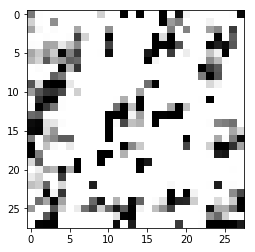

In [28]:
test_noise = np.random.rand(1, 100)
generator_image = generator.predict(test_noise)
generator_image = generator_image.reshape(28,28)
plt.imshow(generator_image,cmap='gray')

In [29]:
epoch_g_loss = []
epoch_d_loss = []
progress_bar = Progbar(target=number_of_batch)
for index in range(number_of_batch):
    progress_bar.update(index)
    noise = np.random.rand(batch_size, 100)
    real_batch = X_train[index * batch_size:(index + 1) * batch_size]
    fake_batch = generator.predict(noise)
    img_batch  = np.concatenate((real_batch,fake_batch), axis=0)
    #Train Discriminator First
    epoch_d_loss.append(discriminator.train_on_batch(img_batch,answer_for_discriminator))
    #print(epoch_d_loss[index])
    noise = np.random.rand(batch_size, 100)
    epoch_g_loss.append(model_for_training_generator.train_on_batch(noise, answer_for_generator))
    #print(epoch_g_loss[index])

3749/3750 [============================>.] - ETA: 0s  

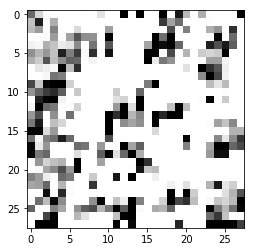

In [30]:
test_noise = np.random.rand(1, 100)
generator_image = generator.predict(test_noise)
generator_image = generator_image.reshape(28,28)
plt.imshow(generator_image,cmap='gray')

In [33]:
epochs = 40

In [ ]:
for epoch in range(epochs):
    print(epoch)
    epoch_g_loss = []
    epoch_d_loss = []
    #progress_bar = Progbar(target=number_of_batch)
    for index in range(number_of_batch):
        #progress_bar.update(index)
        noise = np.random.rand(batch_size, 100)
        real_batch = X_train[index * batch_size:(index + 1) * batch_size]
        fake_batch = generator.predict(noise)
        img_batch  = np.concatenate((real_batch,fake_batch), axis=0)
        #Train Discriminator First
        epoch_d_loss.append(discriminator.train_on_batch(img_batch,answer_for_discriminator))
        #print(epoch_d_loss[index])
        noise = np.random.rand(batch_size, 100)
        epoch_g_loss.append(model_for_training_generator.train_on_batch(noise, answer_for_generator))
        #print(epoch_g_loss[index])
    generator_image = generator.predict(test_noise)
    generator_image = generator_image.reshape(28,28)
    plt.imshow(generator_image,cmap='gray')

0
1
